In [246]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, ConcatDataset
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import re
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score, confusion_matrix, accuracy_score, classification_report, recall_score
from sklearn.manifold import TSNE
from sklearn.model_selection import StratifiedKFold
from collections import Counter
import umap.umap_ as umap
import matplotlib
from sklearn.manifold import Isomap
from os.path import join
import os

from sklearn.neighbors import NearestNeighbors
import pickle
from sklearn.metrics import pairwise_distances
from svae import SupervisedVAE, loss_function

In [247]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import matplotlib.pyplot as plt
from contextlib import contextmanager

plt.style.use("paper.mplstyle")

In [248]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        
        
set_seed(42)

In [249]:
frb_data = pd.read_csv('chimefrbcat1.csv')

frb_data.head()

def is_repeater(repeater_name):
    return 1 if repeater_name != "-9999" else 0

# Create a new column 'repeater' based on 'repeater_name', if repeater_name is not -9999, set to 1, else 0
frb_data['repeater'] = frb_data['repeater_name'].apply(is_repeater)

In [250]:
frb_data["mjd_400"] = pd.to_numeric(frb_data["mjd_400"], errors="coerce")

PREC = 6  # use 3 if that is what is needed

frb_data["mjd_400_r"] = frb_data["mjd_400"].round(PREC)


# round MJD to the nearest 3 decimal places
mask = frb_data["repeater"] == 0
frb_data = pd.concat([
    frb_data[mask].drop_duplicates(subset=["tns_name", "mjd_400_r"], keep="first"),
    frb_data[~mask]
])

frb_data = frb_data.sort_index()

frb_data[frb_data['tns_name']=='FRB20190122C'][['mjd_400_r', 'repeater']].values

len(frb_data)

570

In [251]:
labels = frb_data['repeater']

base_features = ['bonsai_dm', 'dm_exc_ne2001', 'dm_exc_ymw16', 'bc_width', 'high_freq', 'low_freq', 'peak_freq']
error_features = ['dm_fitb', 'fluence', 'flux', 'sp_idx', 'sp_run']

all_features = base_features + error_features

for feature in all_features:
    # convert to integer if the feature is not already an integer
    if not pd.api.types.is_integer_dtype(frb_data[feature]):
        frb_data[feature] = pd.to_numeric(frb_data[feature]).astype(int)

for feature in error_features:
    frb_data[f"{feature}_lower"] = frb_data[feature] - frb_data[f'{feature}_err']
    frb_data[f"{feature}_upper"] = frb_data[feature] + frb_data[f'{feature}_err']
    

new_features = [f"{feature}_lower" for feature in error_features] + [f"{feature}_upper" for feature in error_features] + base_features

In [252]:
frb_data_clean = frb_data[new_features].dropna()
scaler = StandardScaler()
frb_data_scaled = scaler.fit_transform(frb_data_clean)

In [253]:
indices = frb_data_clean.index

In [254]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)

full_dataset = ConcatDataset([train_dataset, val_dataset])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [255]:
input_dim = val_tensor.shape[1]
hidden_dim = 256
latent_dim = 10
stop_patience = 8
num_epochs = 150

In [256]:
def evaluate_classifier(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            labels = labels.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    recall = recall_score(all_labels, all_preds, average='weighted')

    
    false_positives = np.sum((all_labels == 0) & (all_preds == 1))

    return accuracy, class_report, conf_matrix, recall, false_positives  # Return F1 score as well

def get_activation_function(name):
    if name == 'ReLU':
        return nn.ReLU()
    elif name == 'LeakyReLU':
        return nn.LeakyReLU(0.1)
    elif name == 'ELU':
        return nn.ELU()
    elif name == 'SELU':
        return nn.SELU()
    elif name == 'GELU':
        return nn.GELU()
    else:
        raise ValueError(f"Unknown activation function: {name}")

In [257]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import sklearn.metrics

def evaluate_classifier_full(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            class_logits = model(data)[-1]
            preds = (class_logits > 0.5).float().cpu().numpy().squeeze()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = sklearn.metrics.f1_score(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, target_names=["Non-Repeater", "Repeater"])
    conf_matrix = confusion_matrix(all_labels, all_preds)
    
    return accuracy, class_report, conf_matrix, all_preds, all_labels

In [258]:
garcia_list = '''
FRB20180907E
FRB20180920B
FRB20180928A
FRB20181017B
FRB20181022E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181214A
FRB20181220A
FRB20181226E
FRB20181229B
FRB20190112A
FRB20190128C
FRB20190206B
FRB20190206A
FRB20190218B
FRB20190223A
FRB20190308C
FRB20190308C
FRB20190323D
FRB20190329A
FRB20190410A
FRB20190412B
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190527A
FRB20190527A
FRB20190601C
FRB20190601C
FRB20190617B
FRB20180910A
FRB20190210C
FRB20200726D
'''.split()

luo_list = '''
FRB20181229B
FRB20190423B
FRB20190410A
FRB20181017B
FRB20181128C
FRB20190422A
FRB20190409B
FRB20190329A
FRB20190423B
FRB20190206A
FRB20190128C
FRB20190106A
FRB20190129A
FRB20181030E
FRB20190527A
FRB20190218B
FRB20190609A
FRB20190412B
FRB20190125B
FRB20181231B
FRB20181221A
FRB20190112A
FRB20190125A
FRB20181218C
FRB20190429B
FRB20190109B
FRB20190206B
'''.split()

zhu_ge_list = '''
FRB20180911A
FRB20180915B
FRB20180920B
FRB20180923A
FRB20180923C
FRB20180928A
FRB20181013E
FRB20181017B
FRB20181030E
FRB20181125A
FRB20181125A
FRB20181125A
FRB20181130A
FRB20181214A
FRB20181220A
FRB20181221A
FRB20181226E
FRB20181229B
FRB20181231B
FRB20190106B
FRB20190109B
FRB20190110C
FRB20190111A
FRB20190112A
FRB20190129A
FRB20190204A
FRB20190206A
FRB20190218B
FRB20190220A
FRB20190221A
FRB20190222B
FRB20190223A
FRB20190228A
FRB20190308C
FRB20190308C
FRB20190308B
FRB20190308B
FRB20190323D
FRB20190329A
FRB20190403E
FRB20190409B
FRB20190410A
FRB20190412B
FRB20190418A
FRB20190419A
FRB20190422A
FRB20190422A
FRB20190423A
FRB20190423B
FRB20190423B
FRB20190429B
FRB20190430A
FRB20190517C
FRB20190527A
FRB20190527A
FRB20190531C
FRB20190601B
FRB20190601C
FRB20190601C
FRB20190609A
FRB20190617A
FRB20190617B
FRB20190618A
FRB20190625A
'''.split()

In [ ]:
best_params = best_params = {'hidden_dim': 1530, 'latent_dim': 16, 'beta': 1.2211908840673436, 'gamma': 0.5885532829581379, 'dropout_rate': 0.10966445430577035, 'lr': 0.00013082216688850454, 'scheduler_patience': 7, 'class_weight': 0.8946298975578247, 'activation': 'ReLU', 'classification_multiplier': 12452.143276136809}


lr = best_params["lr"]
scheduler_patience = best_params["scheduler_patience"]
num_epochs = 150

In [ ]:
full_model = SupervisedVAE(
        input_dim,
        best_params["hidden_dim"],
        best_params["latent_dim"],
        best_params["dropout_rate"],
        get_activation_function(best_params["activation"])
    ).to(device)

full_model.load_state_dict(torch.load(f"saves/trial_224/model_fold_2.pth", map_location=device))


<All keys matched successfully>

In [261]:
train_data, val_data, train_labels, val_labels, train_indices, val_indices = train_test_split(
    frb_data_scaled, labels, indices, test_size=0.2, random_state=42, stratify=labels
)

source_data_val = list(frb_data.loc[val_indices, "tns_name"])
source_data_val

source_data_train = list(frb_data.loc[train_indices, "tns_name"])
source_data_full = source_data_train + source_data_val


def get_source_data_freq(data_list, n=20):
    label_counts = Counter(data_list)
    top_labels = [label for label, _ in label_counts.most_common(n)]
    source_data_freq = [label if label in top_labels else 'Other' for label in data_list]

    return source_data_freq


# Convert to PyTorch tensors
train_tensor = torch.tensor(train_data, dtype=torch.float32)
val_tensor = torch.tensor(val_data, dtype=torch.float32)
train_labels_tensor = torch.tensor(train_labels.values, dtype=torch.long)
val_labels_tensor = torch.tensor(val_labels.values, dtype=torch.long)

# Create datasets and dataloaders
batch_size = 64
train_dataset = TensorDataset(train_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_tensor, val_labels_tensor)
full_dataset = ConcatDataset([train_dataset, val_dataset])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)


def get_latent_representations(model, dataloader, device):
    model.eval()
    latent_representations = []
    all_labels = []
    with torch.no_grad():
        for data, labels in dataloader:
            data = data.to(device)
            mu, _ = model.encode(data)
            latent_representations.append(mu.cpu().numpy())
            all_labels.append(labels.numpy())
    return np.concatenate(latent_representations), np.concatenate(all_labels)

train_latent, train_labels_np = get_latent_representations(full_model, train_loader, device)
val_latent, val_labels_np = get_latent_representations(full_model, val_loader, device)
val_labels_string = np.array(['Repeater' if l == 1 else 'Non-repeater' for l in val_labels_np])
full_data_latent, full_data_labels = get_latent_representations(full_model, full_loader, device)
full_data_labels_string = np.array(['Repeater' if l == 1 else 'Non-repeater' for l in full_data_labels])


In [262]:
global_font_size = 26
global_figsize = (10, 6)  

In [263]:
def natural_keys(text):
    return [int(c) if c.isdigit() else c.lower() for c in re.split(r'(\d+)', text)]

In [264]:
top = 0.97
bottom = 0.17
left = 0.03
right = 0.68

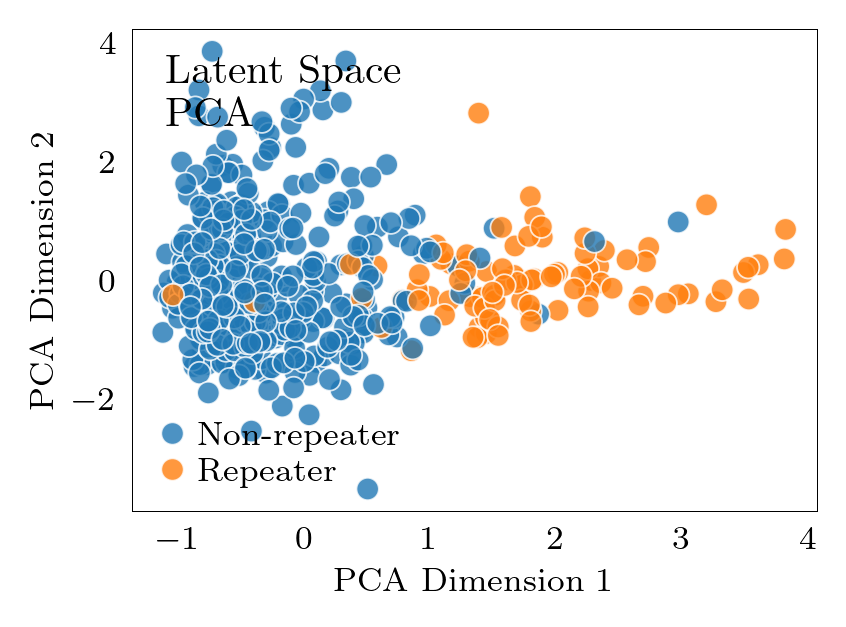

In [265]:
pt = 1./72.27
BASE_WIDTH = 440.0 * pt  # Full text width in inches

@contextmanager
def scaled_plot_params(width_ratio=1.0):
    # Store original rcParams
    original_params = {
        'lines.linewidth': plt.rcParams['lines.linewidth'],
        'axes.linewidth': plt.rcParams['axes.linewidth'],
        'xtick.major.width': plt.rcParams['xtick.major.width'],
        'ytick.major.width': plt.rcParams['ytick.major.width'],
        'grid.linewidth': plt.rcParams['grid.linewidth'],
    }
    
    scale_factor = width_ratio
    
    plt.rcParams.update({
        'lines.linewidth': 0.5 * scale_factor,
        'axes.linewidth': 0.5 * scale_factor,
        'xtick.major.width': 0.3 * scale_factor,
        'ytick.major.width': 0.3 * scale_factor,
        'grid.linewidth': 0.2 * scale_factor,
    })
    
    try:
        yield scale_factor
    finally:
        plt.rcParams.update(original_params)


def visualize_latent_space_pca(latent_representations, labels,
                               title='PCA of Latent Space Representations',
                               file_path='new_figs', loc='upper right', 
                               palette='tab10', label_pos=(0.05, 0.95),
                               width_ratio=1.0):

    pca = PCA(n_components=2)
    latent_2d = pca.fit_transform(latent_representations)
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)
    
    # Calculate scaled width
    fig_width = BASE_WIDTH * width_ratio
    
    with scaled_plot_params(width_ratio) as scale_factor:
        fig, ax = plt.subplots(figsize=(fig_width, fig_width*(0.75)))
        
        # Scale marker size proportionally
        marker_size = 60 * scale_factor
        
        sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                        hue=labels, palette=palette,
                        s=marker_size, alpha=0.8, ax=ax)

        ax.set_xlabel('PCA Dimension 1')
        ax.set_ylabel('PCA Dimension 2')

        handles, labels_ = ax.get_legend_handles_labels()
        if 'Class' in labels_:
            handles, labels_ = handles[1:], labels_[1:]

        sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
        labels_, handles = zip(*sorted_pairs)
    
        ax.text(label_pos[0], label_pos[1], 'Latent Space \n PCA', 
                transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        
        plt.tight_layout()
        if not os.path.exists(file_path):
            os.makedirs(file_path)
            
        # set legend to loc
        ax.legend(handles, labels_, 
                  borderpad=0.2,
                  labelspacing=0.2,
                  loc=loc,
                  handlelength=1,
                  handletextpad=0.3,
                  borderaxespad=0.5,
                )
        
        fig.savefig(join(file_path, f'{title}.pdf'.replace(' ', '_')),
                pad_inches=0.1)

        plt.show()


# 60% width
visualize_latent_space_pca(full_data_latent, full_data_labels_string, 
                          palette='tab10', file_path='new_figs/half',
                          width_ratio=0.48, loc='lower left')

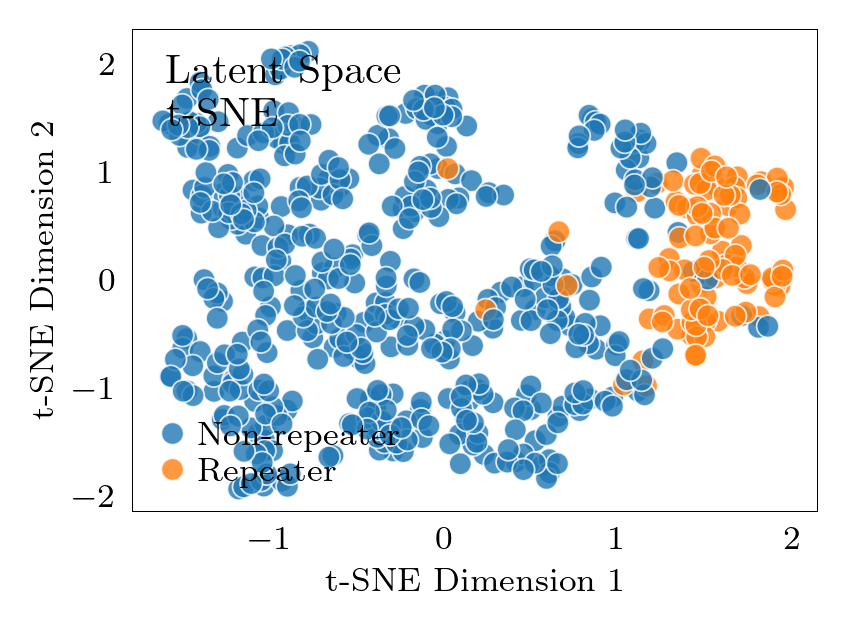

In [266]:
def visualize_latent_space_tsne(latent_representations, labels,
                               title='t-SNE of Latent Space Representations',
                               file_path='new_figs', loc='upper right', 
                               palette='tab10', label_pos=(0.05, 0.95),
                               width_ratio=1.0):

    tsne_transform = TSNE(n_components=2, random_state=42)
    latent_2d = tsne_transform.fit_transform(latent_representations)
    scaler = StandardScaler()
    latent_2d = scaler.fit_transform(latent_2d)
    
    # Calculate scaled width
    fig_width = BASE_WIDTH * width_ratio
    
    with scaled_plot_params(width_ratio) as scale_factor:
        fig, ax = plt.subplots(figsize=(fig_width, fig_width*(0.75)))
        
        # Scale marker size proportionally
        marker_size = 60 * scale_factor
        
        sns.scatterplot(x=latent_2d[:, 0], y=latent_2d[:, 1],
                        hue=labels, palette=palette,
                        s=marker_size, alpha=0.8, ax=ax)

        ax.set_xlabel('t-SNE Dimension 1')
        ax.set_ylabel('t-SNE Dimension 2')

        handles, labels_ = ax.get_legend_handles_labels()
        if 'Class' in labels_:
            handles, labels_ = handles[1:], labels_[1:]

        sorted_pairs = sorted(zip(labels_, handles), key=lambda x: natural_keys(x[0]))
        labels_, handles = zip(*sorted_pairs)
    
        ax.text(label_pos[0], label_pos[1], 'Latent Space \n t-SNE', 
                transform=ax.transAxes,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(facecolor='white', alpha=0, edgecolor='none'))
        
        plt.tight_layout()
        if not os.path.exists(file_path):
            os.makedirs(file_path)
            
        # set legend to loc
        ax.legend(handles, labels_, 
                  borderpad=0.2,
                  labelspacing=0.2,
                  loc=loc,
                  handlelength=1,
                  handletextpad=0.3,
                  borderaxespad=0.5,
                )
        
        fig.savefig(join(file_path, f'{title}.pdf'.replace(' ', '_')),
                pad_inches=0.1)

        plt.show()
        
        
visualize_latent_space_tsne(full_data_latent, full_data_labels_string, 
                          palette='tab10', file_path='new_figs/half',
                          width_ratio=0.48, loc='lower left')

In [267]:
# latents
full_latent, full_y = get_latent_representations(full_model, full_loader, device)
Z = pd.DataFrame(full_latent, columns=[f"z{i}" for i in range(full_latent.shape[1])])

# align to original rows in full_dataset order
Y = pd.Series(full_y, name="repeater")

# original features in physical units
X_std = np.vstack([train_data, val_data])                   # same order as full_dataset
X_phys = scaler.inverse_transform(X_std)
X = pd.DataFrame(X_phys, columns=new_features)

df_latent = pd.concat([Z, Y, X.reset_index(drop=True)], axis=1)
df_latent

,z0,z1,z2,z3,z4,z5,z6,z7,z8,z9,...,flux_upper,sp_idx_upper,sp_run_upper,bonsai_dm,dm_exc_ne2001,dm_exc_ymw16,bc_width,high_freq,low_freq,peak_freq
0,-0.317741,0.018819,0.335324,-0.842446,0.568610,0.717503,-0.132259,-0.356159,-0.373865,1.291507,...,0.34,1.40,1.40,211.0,187.0,187.0,0.0,800.0,400.0,400.0
1,-1.093698,-0.402915,0.254742,-0.460638,-0.241106,-0.184362,1.412401,1.130810,-0.487327,0.156208,...,0.25,33.60,-62.00,703.0,539.0,482.0,0.0,528.0,400.0,453.0
2,-0.289507,0.043399,0.234192,-0.166955,-0.276272,-0.071111,0.393827,-0.326235,-0.070129,-0.168203,...,0.25,28.70,-77.00,420.0,380.0,387.0,0.0,542.0,400.0,461.0
3,-0.334975,-0.153286,0.157643,-0.168939,0.469417,0.216401,-0.085415,1.618289,-0.064569,0.812341,...,0.35,1.60,-0.50,1020.0,835.0,784.0,0.0,800.0,400.0,457.0
4,-0.494936,-1.415365,-1.190446,0.388099,-2.381982,0.004480,1.353801,1.672218,-0.262703,0.361556,...,2.71,58.30,-44.20,968.0,942.0,949.0,0.0,800.0,560.0,696.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
565,-0.687304,-0.020016,0.322860,-0.487395,0.344852,0.236852,0.174513,0.256417,-0.302096,0.403937,...,1.52,5.30,-13.30,533.0,511.0,510.0,0.0,671.0,400.0,463.0
566,-0.101118,0.386984,-0.248262,1.065363,-0.233950,-0.954025,0.042916,-1.729148,0.641044,-1.929931,...,1.44,53.80,-163.00,349.0,149.0,23.0,0.0,514.0,410.0,459.0
567,-0.355717,-0.245123,0.010478,0.230119,-0.319344,-0.051770,-0.127830,0.604064,0.288822,0.004526,...,0.26,23.10,-22.10,752.0,692.0,689.0,0.0,707.0,408.0,537.0
568,-0.256620,-0.980438,-0.766075,0.427303,-1.704746,-0.115640,0.903691,1.864929,0.158096,0.306781,...,1.59,43.30,-33.80,1188.0,1084.0,1050.0,0.0,800.0,515.0,656.0


In [268]:
def prettify_features(feature_name):
    pretty_label = ""
    if 'dm_fitb' in feature_name:
        pretty_label += 'DM (Fitburst)'
    if 'fluence' in feature_name:
        pretty_label += 'Fluence'
    if 'flux' in feature_name:
        pretty_label += 'Flux'
    if 'sp_idx' in feature_name:
        pretty_label += 'Spectral Index'
    if 'sp_run' in feature_name:
        pretty_label += 'Spectral Running'
    if 'bonsai' in feature_name:
        pretty_label += 'DM (Bonsai)'
    if 'dm_exc_ne2001' in feature_name:
        pretty_label += 'DM Excess (NE2001)'
    if 'dm_exc_ymw16' in feature_name:
        pretty_label += 'DM Excess (YMW16)'
    if 'width' in feature_name:
        pretty_label += 'Width'
    if 'freq' in feature_name:
        pretty_label += 'Frequency'
    
    if 'lower' in feature_name:
        pretty_label += ' (L)'
        return pretty_label
    if 'upper' in feature_name:
        pretty_label += ' (U)'
        return pretty_label
    
    if 'high' in feature_name:
        pretty_label = 'High ' + pretty_label
        return pretty_label
    if 'low' in feature_name:
        pretty_label = 'Low ' + pretty_label
        return pretty_label
    if 'peak' in feature_name:
        pretty_label = 'Peak ' + pretty_label
        return pretty_label
    
    return pretty_label

In [269]:
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(full_latent)
Z_pca_df = pd.DataFrame(Z_pca, columns=[f"PC{i+1}" for i in range(2)])

df_pca_combined = pd.concat([Z_pca_df, X.reset_index(drop=True)], axis=1)



pear_pca = df_pca_combined.corr(method="pearson").loc[Z_pca_df.columns, X.columns].T
spear_pca = df_pca_combined.corr(method="spearman").loc[Z_pca_df.columns, X.columns].T

spear_pca.index = [prettify_features(col) for col in spear_pca.index]

tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(full_latent)
Z_tsne_df = pd.DataFrame(Z_tsne, columns=[f"TSNE{i+1}" for i in range(2)])

df_tsne_combined = pd.concat([Z_tsne_df, X.reset_index(drop=True)], axis=1)

spear_tsne = df_tsne_combined.corr(method="spearman").loc[Z_tsne_df.columns, X.columns].T


In [270]:
width_ratio = 0.6

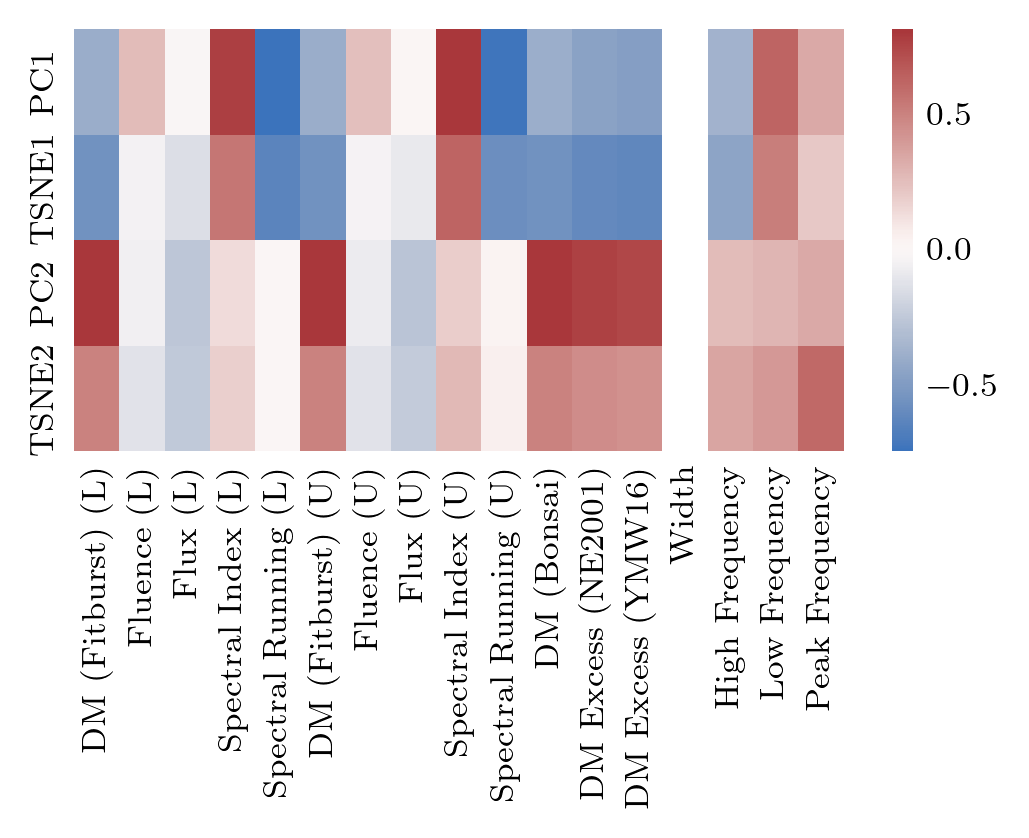

In [271]:
# PCA on latent space
pca = PCA(n_components=2)
Z_pca = pca.fit_transform(full_latent)
Z_pca_df = pd.DataFrame(Z_pca, columns=[f"PC{i+1}" for i in range(2)])
df_pca_combined = pd.concat([Z_pca_df, X.reset_index(drop=True)], axis=1)

# Correlations
pear_pca = df_pca_combined.corr(method="pearson").loc[Z_pca_df.columns, X.columns].T
spear_pca = df_pca_combined.corr(method="spearman").loc[Z_pca_df.columns, X.columns].T

# Apply prettify_features to feature labels
spear_pca.index = [prettify_features(col) for col in spear_pca.index]

# t-SNE on latent space
tsne = TSNE(n_components=2, random_state=42)
Z_tsne = tsne.fit_transform(full_latent)
Z_tsne_df = pd.DataFrame(Z_tsne, columns=[f"TSNE{i+1}" for i in range(2)])
df_tsne_combined = pd.concat([Z_tsne_df, X.reset_index(drop=True)], axis=1)

# Correlations for t-SNE
spear_tsne = df_tsne_combined.corr(method="spearman").loc[Z_tsne_df.columns, X.columns].T
spear_tsne.index = [prettify_features(col) for col in spear_tsne.index]

# Combine both PCA and t-SNE Spearman correlations
spear_combined = pd.concat([spear_pca, spear_tsne], axis=1)
spear_combined.columns = ["PC1", "PC2", "TSNE1", "TSNE2"]
spear_combined = spear_combined[["PC1", "TSNE1", "PC2", "TSNE2"]].T


# Plot combined heatmap
plt.figure(figsize=(BASE_WIDTH * width_ratio, BASE_WIDTH * width_ratio * 0.8))
sns.heatmap(spear_combined, cmap="vlag", center=0)
plt.tight_layout()
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(length=0)
plt.savefig('new_figs/latent_pca_tsne_spearman_heatmap.pdf', pad_inches=0.1)
plt.show()

In [272]:
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

# spearman rho and p
rho_mat = pd.DataFrame(index=Z.columns, columns=X.columns, dtype=float)
p_mat   = pd.DataFrame(index=Z.columns, columns=X.columns, dtype=float)

pairs = []
pvals = []
for zi in Z.columns:
    for feat in X.columns:
        r, p = spearmanr(Z[zi], X[feat], nan_policy="omit")
        rho_mat.loc[zi, feat] = r
        pairs.append((zi, feat))




rows = []
top_features_by_z = {}
for zi in Z.columns:
    dfz = pd.DataFrame({
        "feature": X.columns,
        "rho": rho_mat.loc[zi].values.astype(float),
    })
    dfz["abs_rho"] = dfz["rho"].abs()
    
    dfz = dfz.sort_values(["abs_rho"], ascending=[False]).reset_index(drop=True)
    top_features_by_z[zi] = dfz["feature"].tolist()

    top1 = dfz.iloc[0]
    top2 = dfz.iloc[1] if len(dfz) > 1 else None

    rows.append({
        "z": zi,
        "top_feature": top1["feature"],
        "rho": float(top1["rho"]),
        "runner_up": (top2["feature"] if top2 is not None else None),
        "runner_up_rho": (float(top2["rho"]) if top2 is not None else None),
    })

axis_table = pd.DataFrame(rows).sort_values(
    ["z"],
).reset_index(drop=True)

print("Axis labels (suggested):")
display(axis_table[[
    "z","top_feature","rho","runner_up","runner_up_rho",
]])

Axis labels (suggested):


/opt/homebrew/lib/python3.11/site-packages/scipy/stats/_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


,z,top_feature,rho,runner_up,runner_up_rho
0,z0,peak_freq,0.669544,low_freq,0.446591
1,z1,peak_freq,-0.432525,low_freq,-0.361811
2,z10,high_freq,-0.676639,peak_freq,-0.654434
3,z11,high_freq,-0.702010,peak_freq,-0.466666
4,z12,sp_idx_upper,-0.550517,sp_run_lower,0.535029
5,z13,sp_run_lower,-0.721131,sp_idx_upper,0.694966
6,z14,high_freq,0.569432,dm_fitb_upper,0.414400
7,z15,sp_idx_upper,0.611465,sp_idx_lower,0.590463
8,z2,peak_freq,-0.772543,high_freq,-0.550960
9,z3,low_freq,0.654879,peak_freq,0.642825


In [273]:
def marginal_with_feature_traversal_full(full_model, full_latent, latent_dim_index,
                                    new_features, decoder, n_grid=50, device=device):
    full_model.eval()
    z_emp = full_latent.copy()
    zs = z_emp[:, latent_dim_index]
    grid = np.linspace(np.min(zs), np.max(zs), n_grid)
    grid = np.linspace(-3, 3, n_grid)  # use standard normal range for better comparison

    data = []
    for v in grid:
        samp = z_emp.copy()
        samp[:, latent_dim_index] = v
        z_t = torch.tensor(samp, dtype=torch.float32, device=device)

        with torch.no_grad():
            logits = full_model.classifier(z_t)
            probs  = torch.sigmoid(logits).cpu().numpy().squeeze()
            x_hat  = decoder(z_t).cpu().numpy()
            # x_phys = scaler.inverse_transform(x_hat) 

        row = {'z_val': float(v),
               'prob_mean': float(probs.mean())}
        for j, f in enumerate(new_features):
            row[f + '_mean'] = float(np.mean(x_hat[:, j]))
        data.append(row)

    df = pd.DataFrame(data)
    return df

# Example usage:
probs = {}

for i in range(len(Z.columns)):
    feat_list = top_features_by_z[f"z{i}"][:2]  # top two features
    df_trav = marginal_with_feature_traversal_full(full_model, full_data_latent, i,
                                            new_features=feat_list, 
                                            decoder=full_model.decode,
                                            n_grid=80, device=device)
    
    delta_prob = df_trav['prob_mean'].max() - df_trav['prob_mean'].min()
    print(delta_prob)
    probs[f"z{i}"] = delta_prob

0.0705840140581131
0.06974520534276962
0.053415752947330475
0.1370365098118782
0.11822983250021935
0.08917541801929474
0.10420718416571617
0.17445328272879124
0.11084508895874023
0.17537152953445911
0.07964982092380524
0.09069234132766724
0.08177494257688522
0.1894558984786272
0.0524689257144928
0.16673930175602436


In [274]:
frb_data_clean.columns

for item in frb_data_clean.columns:
    print(f"'{item}': '{prettify_features(item)}',")

'dm_fitb_lower': 'DM (Fitburst) (L)',
'fluence_lower': 'Fluence (L)',
'flux_lower': 'Flux (L)',
'sp_idx_lower': 'Spectral Index (L)',
'sp_run_lower': 'Spectral Running (L)',
'dm_fitb_upper': 'DM (Fitburst) (U)',
'fluence_upper': 'Fluence (U)',
'flux_upper': 'Flux (U)',
'sp_idx_upper': 'Spectral Index (U)',
'sp_run_upper': 'Spectral Running (U)',
'bonsai_dm': 'DM (Bonsai)',
'dm_exc_ne2001': 'DM Excess (NE2001)',
'dm_exc_ymw16': 'DM Excess (YMW16)',
'bc_width': 'Width',
'high_freq': 'High Frequency',
'low_freq': 'Low Frequency',
'peak_freq': 'Peak Frequency',


In [278]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.colors as mcolors
from contextlib import contextmanager

pt = 1./72.27
BASE_WIDTH = 440.0 * pt  # Full text width in inches
golden = (1 + 5 ** 0.5) / 2


@contextmanager
def scaled_plot_params_with_fonts(width_ratio=1.0):

    original_params = {
        'font.size': plt.rcParams['font.size'],
        'axes.labelsize': plt.rcParams['axes.labelsize'],
        'axes.titlesize': plt.rcParams['axes.titlesize'],
        'xtick.labelsize': plt.rcParams['xtick.labelsize'],
        'ytick.labelsize': plt.rcParams['ytick.labelsize'],
        'legend.fontsize': plt.rcParams['legend.fontsize'],
        'lines.linewidth': plt.rcParams['lines.linewidth'],
        'axes.linewidth': plt.rcParams['axes.linewidth'],
        'xtick.major.width': plt.rcParams['xtick.major.width'],
        'ytick.major.width': plt.rcParams['ytick.major.width'],
        'grid.linewidth': plt.rcParams['grid.linewidth'],
    }
    
    # Scale everything proportionally including fonts
    scale_factor = width_ratio
    
    plt.rcParams.update({
        'axes.labelsize': 10 * scale_factor,
        'axes.titlesize': 10 * scale_factor,
        'xtick.labelsize': 10 * scale_factor,
        'ytick.labelsize': 10 * scale_factor,
        'legend.fontsize': 10 * scale_factor,
        'lines.linewidth': 0.5 * scale_factor,
        'axes.linewidth': 0.5 * scale_factor,
        'xtick.major.width': 0.3 * scale_factor,
        'ytick.major.width': 0.3 * scale_factor,
        'grid.linewidth': 0.2 * scale_factor,
    })
    
    try:
        yield scale_factor
    finally:
        # Restore original parameters
        plt.rcParams.update(original_params)


significant_z_indices = [int(k[1:]) for k, v in probs.items() if v >= 0.1]

/var/folders/pj/hzntchlx2j34g96rbgzm14q00000gn/T/ipykernel_64414/3257757869.py:106: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=0.01 * scale_factor)


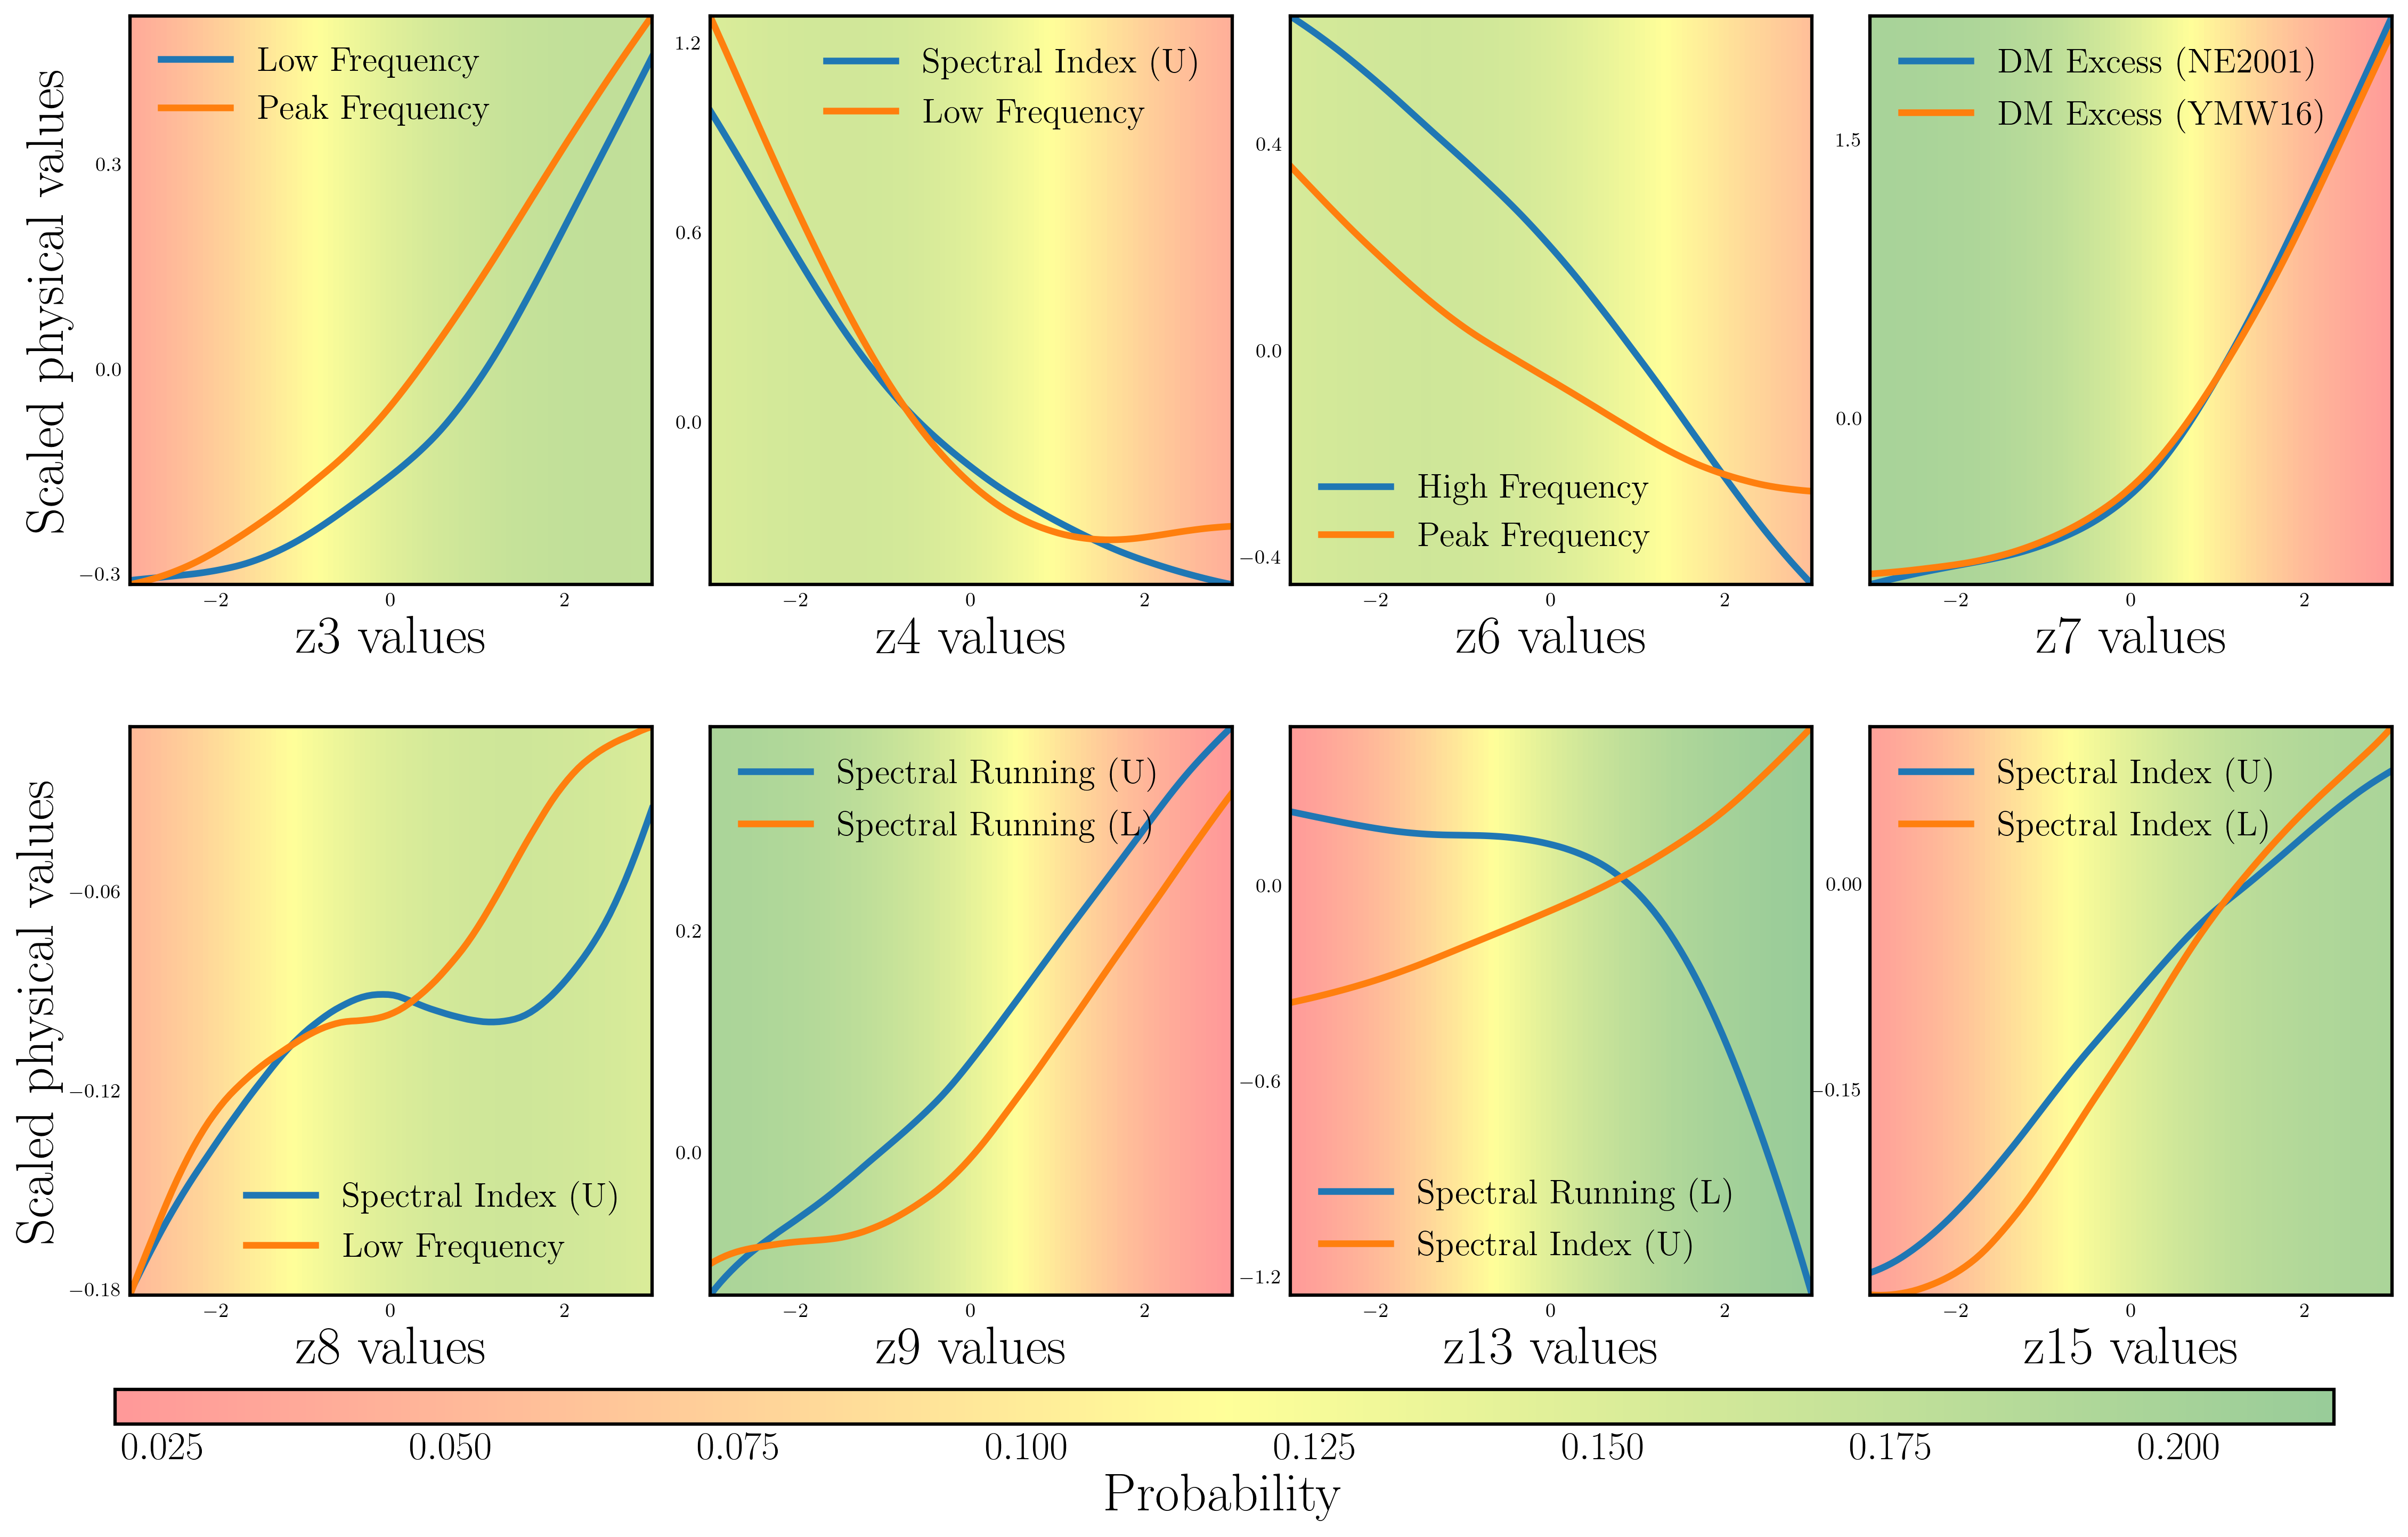

In [281]:
import numpy as np
import os
from os.path import join
from matplotlib.ticker import MaxNLocator
from matplotlib.gridspec import GridSpec

def plot_marginal_traversals(full_model, full_data_latent, top_features_by_z, 
                             new_features, device, n_z=16, width_ratio=1.0,
                             save_path='new_figs'):

    fig_width = BASE_WIDTH * width_ratio

    global_prob_values = []
    for zi in significant_z_indices:
        df = marginal_with_feature_traversal_full(
            full_model, full_data_latent, latent_dim_index=zi,
            new_features=new_features, decoder=full_model.decode,
            n_grid=100, device=device
        )
        global_prob_values.append(df['prob_mean'].values)

    global_prob_values = np.concatenate(global_prob_values)
    prob_min, prob_max = global_prob_values.min(), global_prob_values.max()

    cmap = mcolors.LinearSegmentedColormap.from_list('prob_gradient', ['red', 'yellow', 'green'])
    norm = mpl.colors.Normalize(vmin=prob_min, vmax=prob_max)

    with scaled_plot_params_with_fonts(width_ratio) as scale_factor:
        fig = plt.figure(figsize=(fig_width, fig_width / 1.7))
        gs = GridSpec(nrows=2, ncols=8, figure=fig, hspace=0.25, wspace=0.25)
        
        
        # make a 2 row, 4 column grid of subplots
        axes = []
        for row in range(2):
            for col in range(4):
                ax = fig.add_subplot(gs[row, col*2:(col*2)+2])
                axes.append(ax)
        
        

        # axes = []
        # for i in range(4):
        #     ax = fig.add_subplot(gs[0, 2 * i: 2 * i + 2])
        #     axes.append(ax)

        # bottom_cols = [(1, 3), (3, 5), (5, 7), (7, 9)]
        # for c0, c1 in bottom_cols:
        #     ax = fig.add_subplot(gs[1, c0:c1])
        #     axes.append(ax)

        for idx, (zi, ax) in enumerate(zip(significant_z_indices, axes)):
            feature_list = top_features_by_z[f"z{zi}"][:2]
            df = marginal_with_feature_traversal_full(
                full_model, full_data_latent, latent_dim_index=zi,
                new_features=new_features, decoder=full_model.decode,
                n_grid=100, device=device
            )

            x_vals = df['z_val'].values

            y_min_val = min(df[f + '_mean'].min() for f in feature_list)
            y_max_val = max(df[f + '_mean'].max() for f in feature_list)
            y_range = y_max_val - y_min_val if (y_max_val - y_min_val) != 0 else 1.0
            y_pad = 0.05 * y_range
            y_bottom = y_min_val - y_pad
            y_top = y_max_val + y_pad

            prob_row = df['prob_mean'].values.reshape(1, -1)

            ax.imshow(
                prob_row, aspect='auto', cmap=cmap, alpha=0.4,
                extent=[x_vals.min(), x_vals.max(), y_bottom, y_top],
                origin='lower', norm=norm
            )

            linewidth = 1 * scale_factor
            for f in feature_list:
                pretty_label = prettify_features(f)
                ax.plot(x_vals, df[f + '_mean'].values, label=pretty_label,
                        zorder=2, linewidth=linewidth)

            ax.xaxis.set_major_locator(MaxNLocator(nbins=3))
            ax.yaxis.set_major_locator(MaxNLocator(nbins=3))
            tick_fontsize = 3.0 * scale_factor
            ax.tick_params(axis='both', labelsize=tick_fontsize,
                           length=1.5 * scale_factor, width=0.3 * scale_factor)

            ax.set_xlim(x_vals.min(), x_vals.max())
            ax.set_ylim(y_min_val, y_max_val)

            ax.set_xlabel(f"z{zi} values", fontsize=8 * scale_factor)

            # only keep the ylabel on the first plot of each row
            if idx == 0 or idx == 4:
                ax.set_ylabel("Scaled physical values", fontsize=8 * scale_factor)
            else:
                ax.set_ylabel("")

            legend_fontsize = 5.2 * scale_factor
            ax.legend(fontsize=legend_fontsize, ncol=1, frameon=False)
            



        plt.tight_layout(pad=0.01 * scale_factor)
        fig.subplots_adjust(bottom=0.045 * scale_factor)

        sm = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        cbar_ax = fig.add_axes([0.12, 0.06, 0.76, 0.02])
        cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal', alpha=0.4)
        # make the cbar opacity 0.4
        
        cbar_fontsize = 6 * scale_factor
        cbar.ax.tick_params(size=0, labelsize=cbar_fontsize)
        cbar.set_label("Probability", fontsize=8 * scale_factor)

        os.makedirs(save_path, exist_ok=True)
        plt.savefig(join(save_path, 'marginal_traversals_all_z.pdf'))
        plt.show()


plot_marginal_traversals(full_model, full_data_latent, top_features_by_z, 
                         new_features, device, n_z=16, width_ratio=3.0,
                         save_path='new_figs')

In [283]:
# Plot
print("Latent dimension importance based on marginal classifier traversal:")
probs_sorted = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True))
for k, v in probs_sorted.items():
    if v < 0.1:
        continue
    top_features = top_features_by_z[k][:2]
    better_features = []
    for feature in top_features:
        pretty_name = prettify_features(feature)
        better_features.append(pretty_name)
    print(f"{k} & {', '.join(better_features)} & {v:.4f} \\\\ \\hline")

Latent dimension importance based on marginal classifier traversal:
z13 & Spectral Running (L), Spectral Index (U) & 0.1895 \\ \hline
z9 & Spectral Running (U), Spectral Running (L) & 0.1754 \\ \hline
z7 & DM Excess (NE2001), DM Excess (YMW16) & 0.1745 \\ \hline
z15 & Spectral Index (U), Spectral Index (L) & 0.1667 \\ \hline
z3 & Low Frequency, Peak Frequency & 0.1370 \\ \hline
z4 & Spectral Index (U), Low Frequency & 0.1182 \\ \hline
z8 & Spectral Index (U), Low Frequency & 0.1108 \\ \hline
z6 & High Frequency, Peak Frequency & 0.1042 \\ \hline


In [282]:
for item in best_params.items():
    print(f"'{item[0]}': {item[1]},")

'hidden_dim': 1530,
'latent_dim': 16,
'beta': 1.2211908840673436,
'gamma': 0.5885532829581379,
'dropout_rate': 0.10966445430577035,
'lr': 0.00013082216688850454,
'scheduler_patience': 7,
'class_weight': 0.8946298975578247,
'activation': ReLU,
'classification_multiplier': 12452.143276136809,
